In [132]:
import pandas as pd
import numpy as np
from utils import reduce_memory_usage
from utils import break_datetime
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error,r2_score,mean_absolute_percentage_error,mean_absolute_error
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
import joblib
import zipfile
import os
import category_encoders
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit
import xgboost as xgb
import holidays
import matplotlib.dates as mdates
warnings.filterwarnings('ignore')

In [13]:
df = pd.read_csv('/Users/goksuuzunturk/Desktop/DI 502 Project/FilteredDataset/train.csv').drop('Unnamed: 0',axis=1)
df = df[df['site_id'].isin([1, 6])]
df['log_meter_reading']=np.log1p(df['meter_reading'])
df['log_square_feet']=np.log1p(df['square_feet'])
df= break_datetime(df)
df.head()


,building_id,meter,timestamp,meter_reading,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,...,sea_level_pressure,wind_direction,wind_speed,log_meter_reading,log_square_feet,year,weekofyear,dayofweek,month,hour
3,105,0,2016-01-01,23.3036,1,Education,50623,NaN,5.0,3.8,...,1020.9,240.0,3.1,3.190624,10.832181,2015,53,5,1,0
4,106,0,2016-01-01,0.3746,1,Education,5374,NaN,4.0,3.8,...,1020.9,240.0,3.1,0.318163,8.589514,2015,53,5,1,0
5,107,0,2016-01-01,175.1840,1,Education,97532,2005.0,10.0,3.8,...,1020.9,240.0,3.1,5.171529,11.487946,2015,53,5,1,0
6,108,0,2016-01-01,91.2653,1,Education,81580,1913.0,5.0,3.8,...,1020.9,240.0,3.1,4.524668,11.309352,2015,53,5,1,0
7,109,0,2016-01-01,80.9300,1,Education,56995,1953.0,6.0,3.8,...,1020.9,240.0,3.1,4.405865,10.950736,2015,53,5,1,0


In [48]:
df.groupby('month').building_id.count()

month
1     64538
2     60383
3     64640
4     62636
5     64727
6     62639
7     64714
8     64630
9     62635
10    64716
11    62607
12    64507
Name: building_id, dtype: int64

For each month, the data is balanced

In [52]:
len(df['building_id'].unique())

87

In [15]:
def percent_missing_val(df):

  percent_missing = (df.isnull().sum() * 100) / len(df)
  missing_value_df = pd.DataFrame({'column_name': df.columns,
                                 'percent_missing': percent_missing})
  return missing_value_df

In [16]:
missing_value_df= percent_missing_val(df)
missing_value_df

,column_name,percent_missing
building_id,building_id,0.000000
meter,meter,0.000000
timestamp,timestamp,0.000000
meter_reading,meter_reading,0.000000
site_id,site_id,0.000000
primary_use,primary_use,0.000000
square_feet,square_feet,0.000000
year_built,year_built,53.972899
floor_count,floor_count,41.315898
air_temperature,air_temperature,0.203570


In [17]:
df.drop(['year_built', 'floor_count'], axis=1,inplace=True)

In [18]:
def nan_fillers(df):
  air_temp_df=df.groupby(['site_id', 'dayofweek', 'weekofyear'])['air_temperature'].transform('mean')
  df['air_temperature'].fillna(air_temp_df, inplace=True)

  dew_temp_df=df.groupby(['site_id', 'dayofweek', 'weekofyear'])['dew_temperature'].transform('mean')
  df['dew_temperature'].fillna(dew_temp_df, inplace=True)

  cloud_df=df.groupby(['site_id', 'dayofweek', 'weekofyear'])['cloud_coverage'].transform('mean')
  df['cloud_coverage'].fillna(cloud_df, inplace=True)

  sea_level_df=df.groupby(['site_id', 'dayofweek', 'weekofyear'])['sea_level_pressure'].transform('mean')
  df['sea_level_pressure'].fillna(sea_level_df, inplace=True)

  precip_df=df.groupby(['site_id', 'dayofweek', 'weekofyear'])['precip_depth_1_hr'].transform('mean')
  df['precip_depth_1_hr'].fillna(precip_df, inplace=True)

  wind_dir_df=df.groupby(['site_id', 'dayofweek', 'weekofyear'])['wind_direction'].transform('mean')
  df['wind_direction'].fillna(wind_dir_df, inplace=True)

  wind_speed_df=df.groupby(['site_id', 'dayofweek', 'weekofyear'])['wind_speed'].transform('mean')
  df['wind_speed'].fillna(wind_speed_df, inplace=True)


  return df

In [19]:
df= nan_fillers(df)

In [20]:
df.isnull().sum()

building_id                0
meter                      0
timestamp                  0
meter_reading              0
site_id                    0
primary_use                0
square_feet                0
air_temperature            0
cloud_coverage        167955
dew_temperature            0
precip_depth_1_hr     447978
sea_level_pressure         0
wind_direction             0
wind_speed                 0
log_meter_reading          0
log_square_feet            0
year                       0
weekofyear                 0
dayofweek                  0
month                      0
hour                       0
dtype: int64

In [21]:
df['cloud_coverage'].fillna(df['cloud_coverage'].median(), inplace=True)
df['precip_depth_1_hr'].fillna(df['precip_depth_1_hr'].median(), inplace=True)

# Splitting Points

In [32]:
df=df.sort_values(by='timestamp')

In [114]:
# Initialize time-based cross-validation
tscv = TimeSeriesSplit(n_splits=3)  # You can adjust the number of splits

i = 1
for train_index, test_index in tscv.split(df):
    df_train, df_test = df.iloc[train_index], df.iloc[test_index]
    print('fold :', i)
    print('Train: ',df_train['timestamp'].min(), df_train['timestamp'].max()) 
    print('Test: ',df_test['timestamp'].min(), df_test['timestamp'].max()) 
    i = i + 1 

fold : 1
Train:  2016-01-01 00:00:00 2016-04-01 14:00:00
Test:  2016-04-01 14:00:00 2016-07-02 00:00:00
fold : 2
Train:  2016-01-01 00:00:00 2016-07-02 00:00:00
Test:  2016-07-02 00:00:00 2016-10-01 11:00:00
fold : 3
Train:  2016-01-01 00:00:00 2016-10-01 11:00:00
Test:  2016-10-01 11:00:00 2016-12-31 23:00:00


# XGB

In [67]:
# Circular encoding function
def circular_encode(feature, max_value):
    sin_encoded = np.sin(2 * np.pi * feature / max_value)
    cos_encoded = np.cos(2 * np.pi * feature / max_value)
    return sin_encoded, cos_encoded

# Apply circular encoding to the timestamp features
df['month_sin'], df['month_cos'] = circular_encode(df['month'], 12)
df['hour_sin'], df['hour_cos'] = circular_encode(df['hour'], 24)
df['dayofweek_sin'], df['dayofweek_cos'] = circular_encode(df['dayofweek'], 7)


,building_id,meter,timestamp,meter_reading,site_id,primary_use,square_feet,air_temperature,cloud_coverage,dew_temperature,...,weekofyear,dayofweek,month,hour,month_sin,month_cos,hour_sin,hour_cos,dayofweek_sin,dayofweek_cos
3,105,0,2016-01-01 00:00:00,23.3036,1,Education,50623,3.8,0.000000,2.4,...,53,5,1,0,5.000000e-01,0.866025,0.000000,1.000000,-0.974928,-0.222521
46,148,0,2016-01-01 00:00:00,47.2000,1,Office,174601,3.8,0.000000,2.4,...,53,5,1,0,5.000000e-01,0.866025,0.000000,1.000000,-0.974928,-0.222521
5,107,0,2016-01-01 00:00:00,175.1840,1,Education,97532,3.8,0.000000,2.4,...,53,5,1,0,5.000000e-01,0.866025,0.000000,1.000000,-0.974928,-0.222521
6,108,0,2016-01-01 00:00:00,91.2653,1,Education,81580,3.8,0.000000,2.4,...,53,5,1,0,5.000000e-01,0.866025,0.000000,1.000000,-0.974928,-0.222521
7,109,0,2016-01-01 00:00:00,80.9300,1,Education,56995,3.8,0.000000,2.4,...,53,5,1,0,5.000000e-01,0.866025,0.000000,1.000000,-0.974928,-0.222521
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11530118,781,0,2016-12-31 23:00:00,115.0670,6,Lodging/residential,128044,7.2,0.105263,-7.2,...,52,6,12,23,-2.449294e-16,1.000000,-0.258819,0.965926,-0.781831,0.623490
11530119,782,0,2016-12-31 23:00:00,439.7170,6,Education,129344,7.2,0.105263,-7.2,...,52,6,12,23,-2.449294e-16,1.000000,-0.258819,0.965926,-0.781831,0.623490
11530120,784,0,2016-12-31 23:00:00,503.0830,6,Education,190817,7.2,0.105263,-7.2,...,52,6,12,23,-2.449294e-16,1.000000,-0.258819,0.965926,-0.781831,0.623490
11529474,126,0,2016-12-31 23:00:00,100.8000,1,Education,21539,7.5,0.000000,6.5,...,52,6,12,23,-2.449294e-16,1.000000,-0.258819,0.965926,-0.781831,0.623490


In [69]:
label_enc= LabelEncoder()
label_enc.fit(df['primary_use'])
df['primary_use_encoded'] = label_enc.transform(df['primary_use'])
df


,building_id,meter,timestamp,meter_reading,site_id,primary_use,square_feet,air_temperature,cloud_coverage,dew_temperature,...,dayofweek,month,hour,month_sin,month_cos,hour_sin,hour_cos,dayofweek_sin,dayofweek_cos,primary_use_encoded
3,105,0,2016-01-01 00:00:00,23.3036,1,Education,50623,3.8,0.000000,2.4,...,5,1,0,5.000000e-01,0.866025,0.000000,1.000000,-0.974928,-0.222521,0
46,148,0,2016-01-01 00:00:00,47.2000,1,Office,174601,3.8,0.000000,2.4,...,5,1,0,5.000000e-01,0.866025,0.000000,1.000000,-0.974928,-0.222521,3
5,107,0,2016-01-01 00:00:00,175.1840,1,Education,97532,3.8,0.000000,2.4,...,5,1,0,5.000000e-01,0.866025,0.000000,1.000000,-0.974928,-0.222521,0
6,108,0,2016-01-01 00:00:00,91.2653,1,Education,81580,3.8,0.000000,2.4,...,5,1,0,5.000000e-01,0.866025,0.000000,1.000000,-0.974928,-0.222521,0
7,109,0,2016-01-01 00:00:00,80.9300,1,Education,56995,3.8,0.000000,2.4,...,5,1,0,5.000000e-01,0.866025,0.000000,1.000000,-0.974928,-0.222521,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11530118,781,0,2016-12-31 23:00:00,115.0670,6,Lodging/residential,128044,7.2,0.105263,-7.2,...,6,12,23,-2.449294e-16,1.000000,-0.258819,0.965926,-0.781831,0.623490,2
11530119,782,0,2016-12-31 23:00:00,439.7170,6,Education,129344,7.2,0.105263,-7.2,...,6,12,23,-2.449294e-16,1.000000,-0.258819,0.965926,-0.781831,0.623490,0
11530120,784,0,2016-12-31 23:00:00,503.0830,6,Education,190817,7.2,0.105263,-7.2,...,6,12,23,-2.449294e-16,1.000000,-0.258819,0.965926,-0.781831,0.623490,0
11529474,126,0,2016-12-31 23:00:00,100.8000,1,Education,21539,7.5,0.000000,6.5,...,6,12,23,-2.449294e-16,1.000000,-0.258819,0.965926,-0.781831,0.623490,0


In [75]:
df['is_weekday']=df['dayofweek'] <= 5
df

,building_id,meter,timestamp,meter_reading,site_id,primary_use,square_feet,air_temperature,cloud_coverage,dew_temperature,...,month,hour,month_sin,month_cos,hour_sin,hour_cos,dayofweek_sin,dayofweek_cos,primary_use_encoded,is_weekday
3,105,0,2016-01-01 00:00:00,23.3036,1,Education,50623,3.8,0.000000,2.4,...,1,0,5.000000e-01,0.866025,0.000000,1.000000,-0.974928,-0.222521,0,True
46,148,0,2016-01-01 00:00:00,47.2000,1,Office,174601,3.8,0.000000,2.4,...,1,0,5.000000e-01,0.866025,0.000000,1.000000,-0.974928,-0.222521,3,True
5,107,0,2016-01-01 00:00:00,175.1840,1,Education,97532,3.8,0.000000,2.4,...,1,0,5.000000e-01,0.866025,0.000000,1.000000,-0.974928,-0.222521,0,True
6,108,0,2016-01-01 00:00:00,91.2653,1,Education,81580,3.8,0.000000,2.4,...,1,0,5.000000e-01,0.866025,0.000000,1.000000,-0.974928,-0.222521,0,True
7,109,0,2016-01-01 00:00:00,80.9300,1,Education,56995,3.8,0.000000,2.4,...,1,0,5.000000e-01,0.866025,0.000000,1.000000,-0.974928,-0.222521,0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11530118,781,0,2016-12-31 23:00:00,115.0670,6,Lodging/residential,128044,7.2,0.105263,-7.2,...,12,23,-2.449294e-16,1.000000,-0.258819,0.965926,-0.781831,0.623490,2,False
11530119,782,0,2016-12-31 23:00:00,439.7170,6,Education,129344,7.2,0.105263,-7.2,...,12,23,-2.449294e-16,1.000000,-0.258819,0.965926,-0.781831,0.623490,0,False
11530120,784,0,2016-12-31 23:00:00,503.0830,6,Education,190817,7.2,0.105263,-7.2,...,12,23,-2.449294e-16,1.000000,-0.258819,0.965926,-0.781831,0.623490,0,False
11529474,126,0,2016-12-31 23:00:00,100.8000,1,Education,21539,7.5,0.000000,6.5,...,12,23,-2.449294e-16,1.000000,-0.258819,0.965926,-0.781831,0.623490,0,False


* Site 1: England - London
* Site 6: United States - Philadelphia

In [108]:
# Load holiday data for England
england_holidays = holidays.UnitedKingdom(years=range(2016, 2017))

# Load holiday data for the United States
us_holidays = holidays.UnitedStates(years=range(2016, 2017))

# Initialize 'is_holiday' column with zeros
df['is_holiday'] = 0

# Create 'is_holiday_england' feature
england_mask = df['site_id'] == 1
df.loc[england_mask, 'is_holiday'] = df.loc[england_mask, 'timestamp'].apply(lambda x: 1 if x in england_holidays else 0)

# Create 'is_holiday_us' feature
us_mask = df['site_id'] == 6
df.loc[us_mask, 'is_holiday'] = df.loc[us_mask, 'timestamp'].apply(lambda x: 1 if x in us_holidays else 0)

df

,building_id,meter,timestamp,meter_reading,site_id,primary_use,square_feet,air_temperature,cloud_coverage,dew_temperature,...,hour,month_sin,month_cos,hour_sin,hour_cos,dayofweek_sin,dayofweek_cos,primary_use_encoded,is_weekday,is_holiday
3,105,0,2016-01-01 00:00:00,23.3036,1,Education,50623,3.8,0.000000,2.4,...,0,5.000000e-01,0.866025,0.000000,1.000000,-0.974928,-0.222521,0,True,1
46,148,0,2016-01-01 00:00:00,47.2000,1,Office,174601,3.8,0.000000,2.4,...,0,5.000000e-01,0.866025,0.000000,1.000000,-0.974928,-0.222521,3,True,1
5,107,0,2016-01-01 00:00:00,175.1840,1,Education,97532,3.8,0.000000,2.4,...,0,5.000000e-01,0.866025,0.000000,1.000000,-0.974928,-0.222521,0,True,1
6,108,0,2016-01-01 00:00:00,91.2653,1,Education,81580,3.8,0.000000,2.4,...,0,5.000000e-01,0.866025,0.000000,1.000000,-0.974928,-0.222521,0,True,1
7,109,0,2016-01-01 00:00:00,80.9300,1,Education,56995,3.8,0.000000,2.4,...,0,5.000000e-01,0.866025,0.000000,1.000000,-0.974928,-0.222521,0,True,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11530118,781,0,2016-12-31 23:00:00,115.0670,6,Lodging/residential,128044,7.2,0.105263,-7.2,...,23,-2.449294e-16,1.000000,-0.258819,0.965926,-0.781831,0.623490,2,False,0
11530119,782,0,2016-12-31 23:00:00,439.7170,6,Education,129344,7.2,0.105263,-7.2,...,23,-2.449294e-16,1.000000,-0.258819,0.965926,-0.781831,0.623490,0,False,0
11530120,784,0,2016-12-31 23:00:00,503.0830,6,Education,190817,7.2,0.105263,-7.2,...,23,-2.449294e-16,1.000000,-0.258819,0.965926,-0.781831,0.623490,0,False,0
11529474,126,0,2016-12-31 23:00:00,100.8000,1,Education,21539,7.5,0.000000,6.5,...,23,-2.449294e-16,1.000000,-0.258819,0.965926,-0.781831,0.623490,0,False,0


fold : 1
Train:  2016-01-01 00:00:00 2016-03-02 02:00:00
Test:  2016-03-02 02:00:00 2016-05-02 02:00:00
MSE for train set is:  0.11812145376098859
R2 for train set is:  0.9161822849818525
MAPE for train set is:  0.0705274870522175
MAE for train set is:  0.27206978097770557
MSE for test set is:  0.19537898229813927
R2 for test set is:  0.8672223542725594
MAPE for test set is:  0.08798100506543037
MAE for test set is:  0.2940910831735731
--------------------------------
fold : 2
Train:  2016-01-01 00:00:00 2016-05-02 02:00:00
Test:  2016-05-02 02:00:00 2016-07-02 00:00:00
MSE for train set is:  0.13719012651820137
R2 for train set is:  0.904796454131225
MAPE for train set is:  0.07652084891682208
MAE for train set is:  0.2821820716489813
MSE for test set is:  0.3986647148719381
R2 for test set is:  0.7782746981063742
MAPE for test set is:  5.132335882649394
MAE for test set is:  0.3546028622674695
--------------------------------
fold : 3
Train:  2016-01-01 00:00:00 2016-07-02 00:00:00
T

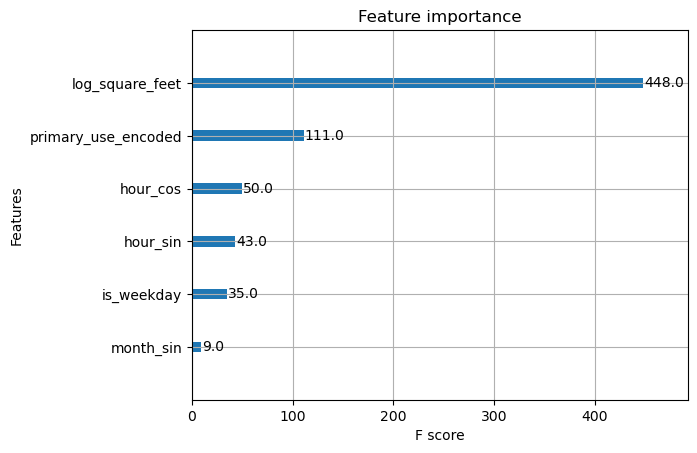

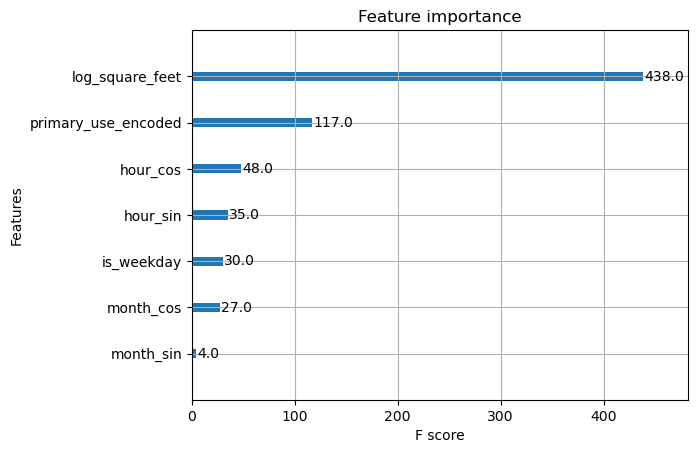

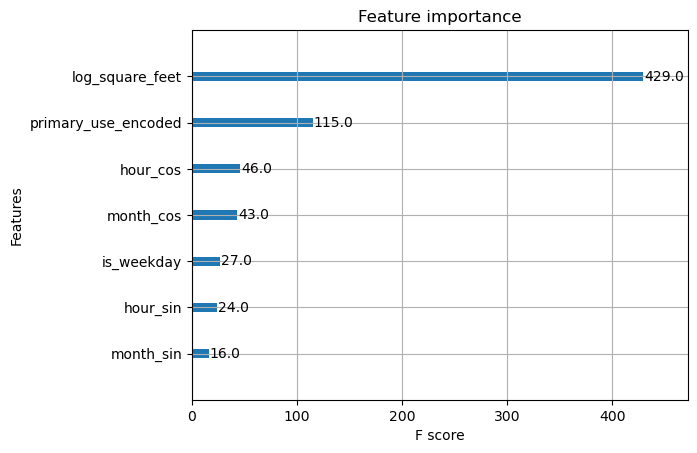

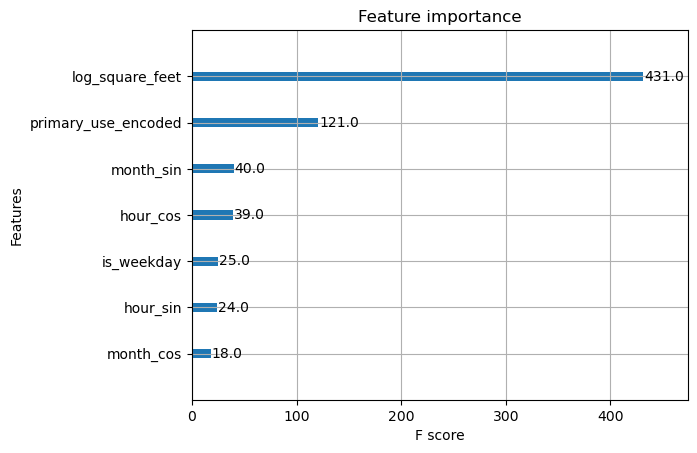

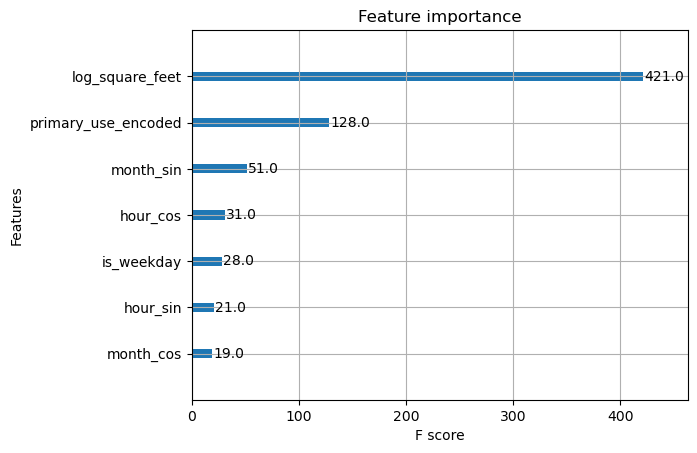

In [140]:
features = ['hour_sin','hour_cos','is_weekday','month_sin','month_cos','log_square_feet', 'primary_use_encoded']
target = 'log_meter_reading'
models = []

tscv = TimeSeriesSplit(n_splits=5)  # You can adjust the number of splits

i = 1
for train_index, test_index in tscv.split(df):
    df_train, df_test = df.iloc[train_index], df.iloc[test_index]
    print('fold :', i)
    print('Train: ',df_train['timestamp'].min(), df_train['timestamp'].max()) 
    print('Test: ',df_test['timestamp'].min(), df_test['timestamp'].max()) 
    i = i + 1 

    X_train = df_train[features]
    X_test = df_test[features]
    y_train = df_train[target]
    y_test = df_test[target]

    XGB = xgb.XGBRegressor(
    objective='reg:squarederror',  # Use 'reg:squarederror' for regression problems
    n_estimators=100,               # Number of boosting rounds (adjust as needed)
    learning_rate=0.1,              # Step size shrinkage to prevent overfitting
    max_depth=3                     # Maximum depth of each tree (adjust as needed)
    )


    XGB.fit(X_train,y_train)
    y_pred_train = XGB.predict(X_train)
    train_error_mse = mean_squared_error(y_train,y_pred_train)
    train_error_r2 = r2_score(y_train,y_pred_train)
    train_error_mape = mean_absolute_percentage_error(y_train,y_pred_train)
    train_error_mae = mean_absolute_error(y_train,y_pred_train)

    print("MSE for train set is: ",train_error_mse)

    print("R2 for train set is: ",train_error_r2)

    print("MAPE for train set is: ",train_error_mape)

    print("MAE for train set is: ",train_error_mae)

    y_pred_test = XGB.predict(X_test)
    test_error_mse = mean_squared_error(y_test,y_pred_test)
    test_error_r2 = r2_score(y_test,y_pred_test)
    test_error_mape = mean_absolute_percentage_error(y_test,y_pred_test)
    test_error_mae = mean_absolute_error(y_test,y_pred_test)

    models.append(XGB)

    print("MSE for test set is: ",test_error_mse)

    print("R2 for test set is: ",test_error_r2)

    print("MAPE for test set is: ",test_error_mape)

    print("MAE for test set is: ",test_error_mae)

    print("--------------------------------")

    xgb.plot_importance(XGB)



fold : 0
Train:  2016-01-01 00:00:00 2016-03-02 02:00:00
Test:  2016-03-02 02:00:00 2016-05-02 02:00:00


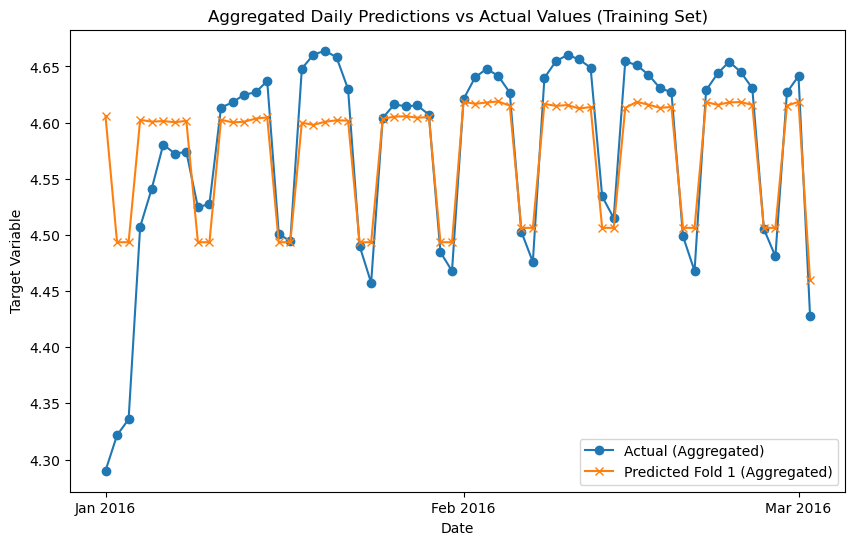

fold : 1
Train:  2016-01-01 00:00:00 2016-05-02 02:00:00
Test:  2016-05-02 02:00:00 2016-07-02 00:00:00


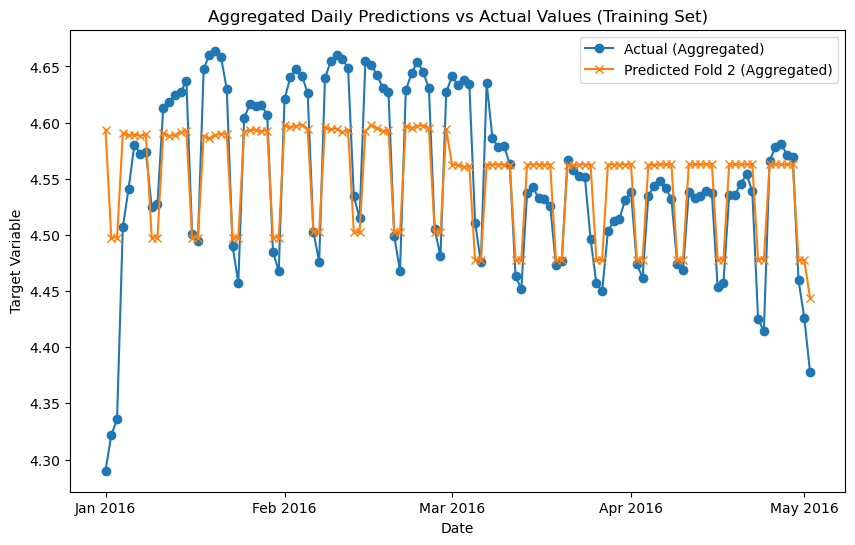

fold : 2
Train:  2016-01-01 00:00:00 2016-07-02 00:00:00
Test:  2016-07-02 00:00:00 2016-09-01 00:00:00


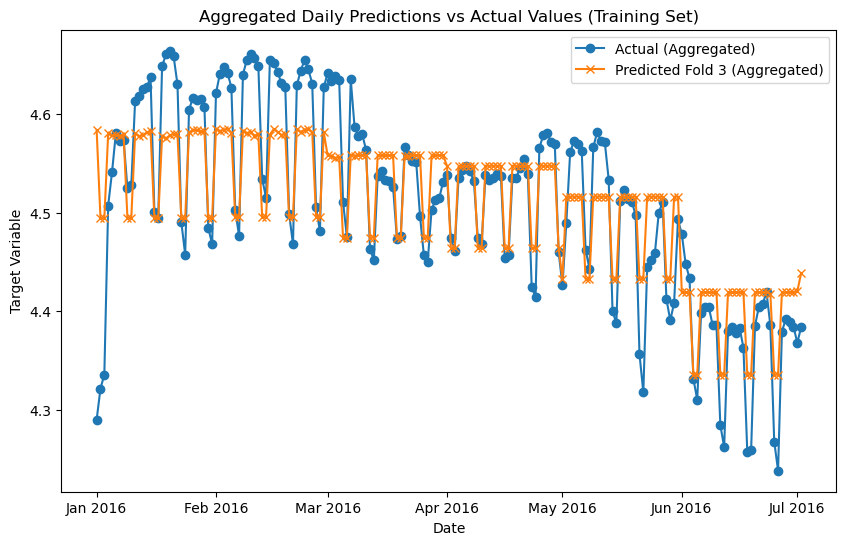

fold : 3
Train:  2016-01-01 00:00:00 2016-09-01 00:00:00
Test:  2016-09-01 00:00:00 2016-10-31 22:00:00


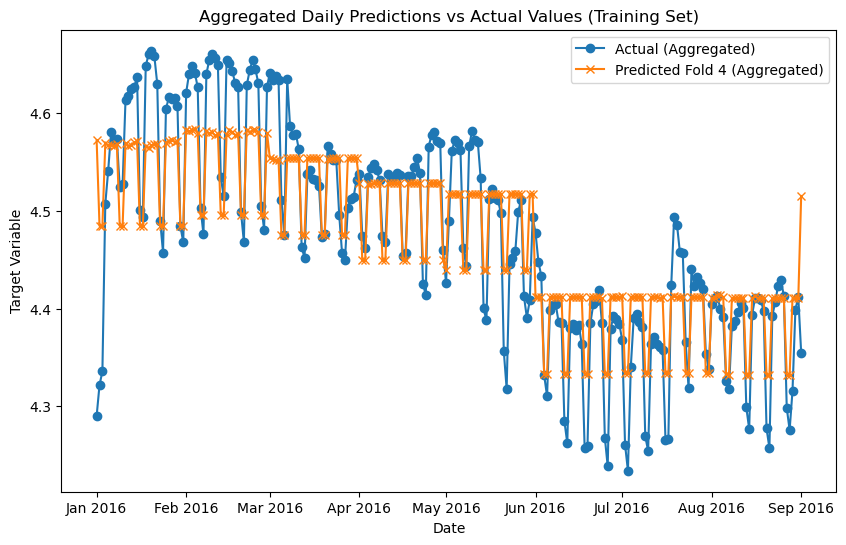

fold : 4
Train:  2016-01-01 00:00:00 2016-10-31 22:00:00
Test:  2016-10-31 22:00:00 2016-12-31 23:00:00


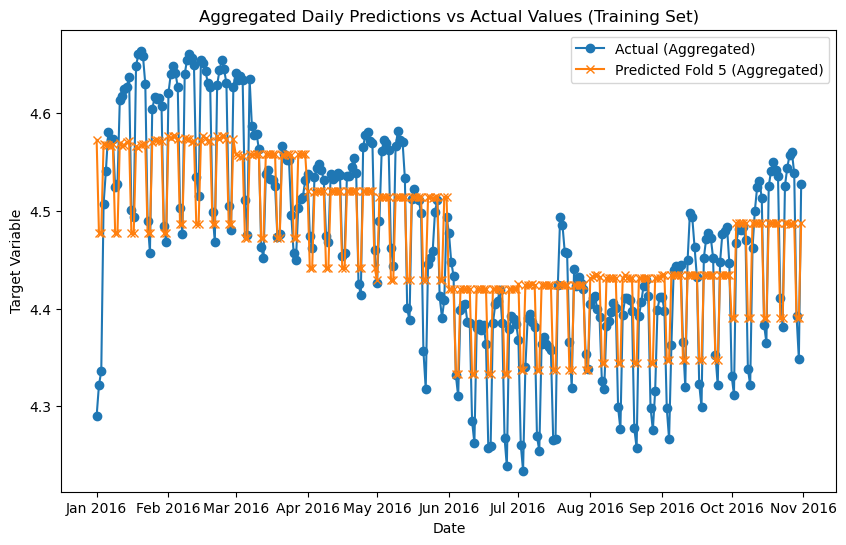

In [138]:
i = 0
for train_index, test_index in tscv.split(df):
    df_train, df_test = df.iloc[train_index], df.iloc[test_index]
    print('fold :', i)
    print('Train: ',df_train['timestamp'].min(), df_train['timestamp'].max()) 
    print('Test: ',df_test['timestamp'].min(), df_test['timestamp'].max()) 
    i = i + 1 

    X_train = df_train[features]
    X_test = df_test[features]
    y_train = df_train[target]
    y_test = df_test[target]

    XGB = xgb.XGBRegressor(
    objective='reg:squarederror',  # Use 'reg:squarederror' for regression problems
    n_estimators=100,               # Number of boosting rounds (adjust as needed)
    learning_rate=0.1,              # Step size shrinkage to prevent overfitting
    max_depth=3                     # Maximum depth of each tree (adjust as needed)
    )


    XGB.fit(X_train,y_train)
    
    y_pred_train = XGB.predict(X_train)
    y_pred_test = XGB.predict(X_test)

    # DataFrames to store aggregated values for all folds
    aggregated_actual_df = pd.DataFrame()
    aggregated_predicted_df = pd.DataFrame()

    #Add timestamp and predictions to DataFrames
    aggregated_actual_df = pd.concat([aggregated_actual_df, pd.DataFrame({'timestamp': df_train['timestamp'], 'actual': y_train})])
    aggregated_predicted_df = pd.concat([aggregated_predicted_df, pd.DataFrame({'timestamp': df_train['timestamp'], f'predicted_fold_{i}': y_pred_train})])
    
    # Group by timestamp and resample on a daily basis
    aggregated_actual_df.set_index('timestamp', inplace=True)
    aggregated_predicted_df.set_index('timestamp', inplace=True)

    aggregated_actual_daily = aggregated_actual_df.resample('D').mean()
    aggregated_predicted_daily = aggregated_predicted_df.resample('D').mean()

    # Plotting aggregated daily predictions for all folds
    plt.figure(figsize=(10, 6))
    plt.plot(aggregated_actual_daily.index, aggregated_actual_daily['actual'], label='Actual (Aggregated)', marker='o')
    plt.plot(aggregated_predicted_daily.index, aggregated_predicted_daily[f'predicted_fold_{i}'], label=f'Predicted Fold {i} (Aggregated)', marker='x')
    plt.title('Aggregated Daily Predictions vs Actual Values (Training Set)')
    plt.xlabel('Date')
    plt.ylabel('Target Variable')
    plt.legend()
    # Format x-axis ticks as months
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator())    

    plt.show()

  

fold : 0
Train:  2016-01-01 00:00:00 2016-03-02 02:00:00
Test:  2016-03-02 02:00:00 2016-05-02 02:00:00


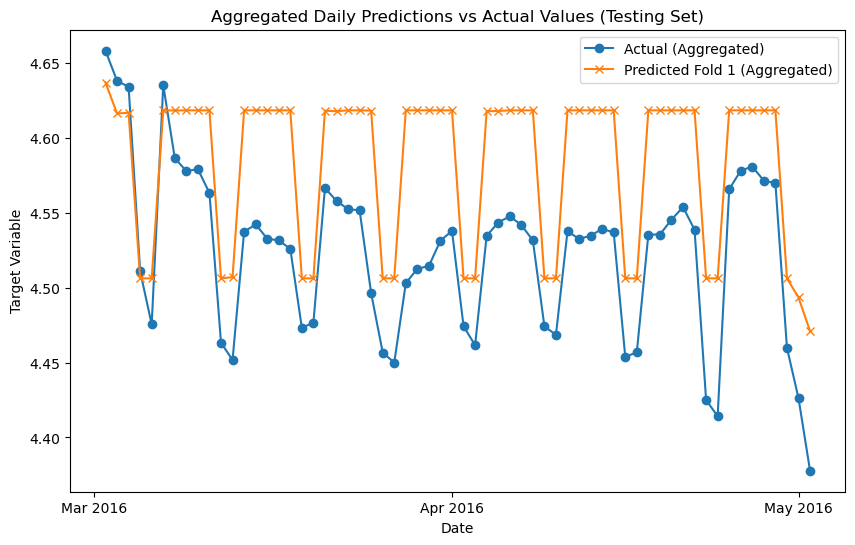

fold : 1
Train:  2016-01-01 00:00:00 2016-05-02 02:00:00
Test:  2016-05-02 02:00:00 2016-07-02 00:00:00


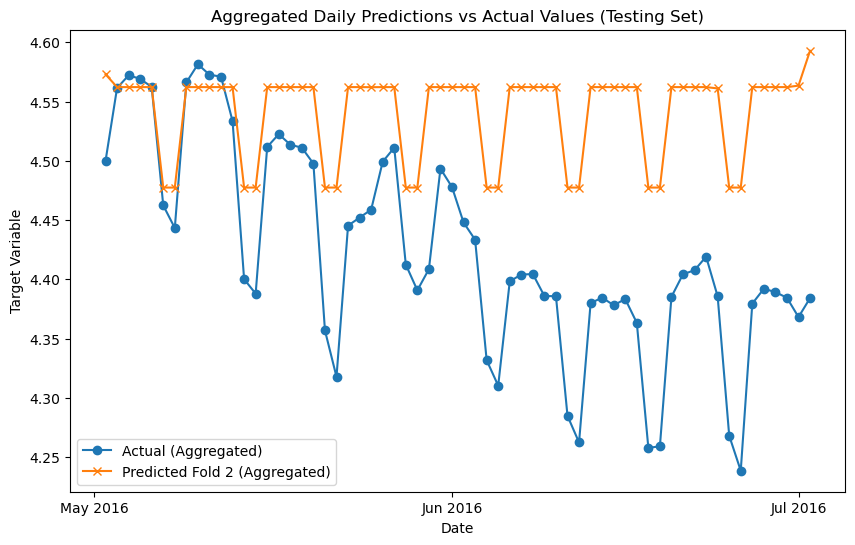

fold : 2
Train:  2016-01-01 00:00:00 2016-07-02 00:00:00
Test:  2016-07-02 00:00:00 2016-09-01 00:00:00


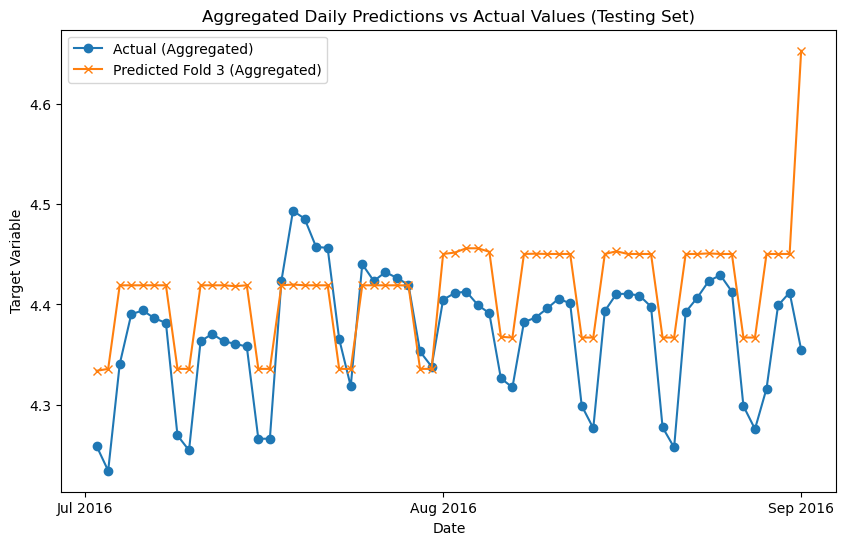

fold : 3
Train:  2016-01-01 00:00:00 2016-09-01 00:00:00
Test:  2016-09-01 00:00:00 2016-10-31 22:00:00


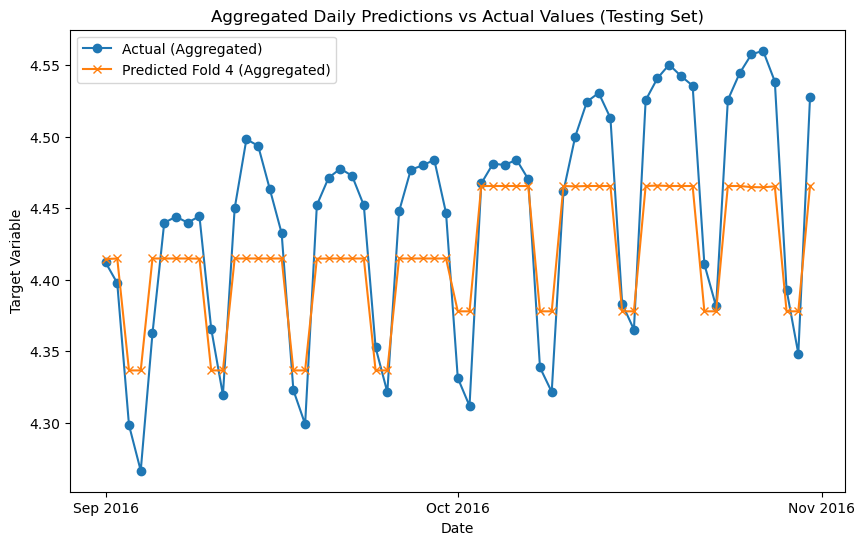

fold : 4
Train:  2016-01-01 00:00:00 2016-10-31 22:00:00
Test:  2016-10-31 22:00:00 2016-12-31 23:00:00


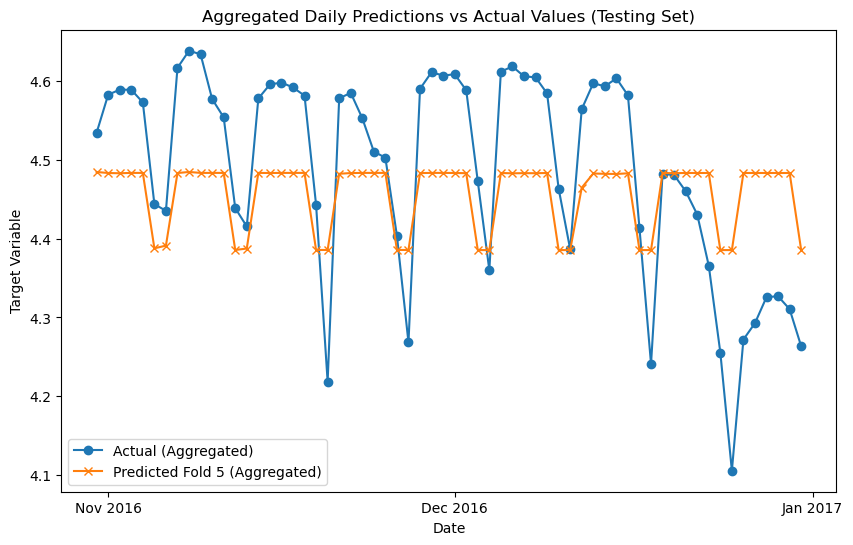

In [136]:
i = 0
for train_index, test_index in tscv.split(df):
    df_train, df_test = df.iloc[train_index], df.iloc[test_index]
    print('fold :', i)
    print('Train: ',df_train['timestamp'].min(), df_train['timestamp'].max()) 
    print('Test: ',df_test['timestamp'].min(), df_test['timestamp'].max()) 
    i = i + 1 

    X_train = df_train[features]
    X_test = df_test[features]
    y_train = df_train[target]
    y_test = df_test[target]

    XGB = xgb.XGBRegressor(
    objective='reg:squarederror',  # Use 'reg:squarederror' for regression problems
    n_estimators=100,               # Number of boosting rounds (adjust as needed)
    learning_rate=0.1,              # Step size shrinkage to prevent overfitting
    max_depth=3                     # Maximum depth of each tree (adjust as needed)
    )


    XGB.fit(X_train,y_train)
    
    y_pred_train = XGB.predict(X_train)
    y_pred_test = XGB.predict(X_test)

    # DataFrames to store aggregated values for all folds
    aggregated_actual_df = pd.DataFrame()
    aggregated_predicted_df = pd.DataFrame()

    #Add timestamp and predictions to DataFrames
    aggregated_actual_df = pd.concat([aggregated_actual_df, pd.DataFrame({'timestamp': df_test['timestamp'], 'actual': y_test})])
    aggregated_predicted_df = pd.concat([aggregated_predicted_df, pd.DataFrame({'timestamp': df_test['timestamp'], f'predicted_fold_{i}': y_pred_test})])
    
    # Group by timestamp and resample on a daily basis
    aggregated_actual_df.set_index('timestamp', inplace=True)
    aggregated_predicted_df.set_index('timestamp', inplace=True)

    aggregated_actual_daily = aggregated_actual_df.resample('D').mean()
    aggregated_predicted_daily = aggregated_predicted_df.resample('D').mean()

    # Plotting aggregated daily predictions for all folds
    plt.figure(figsize=(10, 6))
    plt.plot(aggregated_actual_daily.index, aggregated_actual_daily['actual'], label='Actual (Aggregated)', marker='o')
    plt.plot(aggregated_predicted_daily.index, aggregated_predicted_daily[f'predicted_fold_{i}'], label=f'Predicted Fold {i} (Aggregated)', marker='x')
    plt.title('Aggregated Daily Predictions vs Actual Values (Testing Set)')
    plt.xlabel('Date')
    plt.ylabel('Target Variable')
    plt.legend()
    # Format x-axis ticks as months
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator())    

    plt.show()

  